In [1]:
from PIL import Image
import os.path, sys
from skimage.io import imread, imshow
import cv2
from skimage import data, color, feature , exposure
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
from skimage.transform import resize
from skimage.feature import hog
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns; sns.set()
import glob
import os

from _helper_functions import resize_aspect_fit , get_hog_feat

# --------------------------------Train Data------------------------------------------

In [2]:
path = '/Users/toothless/Downloads/Thesis/data/Train/original/cancer/'
can_re = resize_aspect_fit(path,150)

In [3]:
path = '/Users/toothless/Downloads/Thesis/data/Train/original/_nocancer/'
ncan_re = resize_aspect_fit(path,150)

In [4]:
can_hog_im , can_hog_feat = get_hog_feat(can_re)

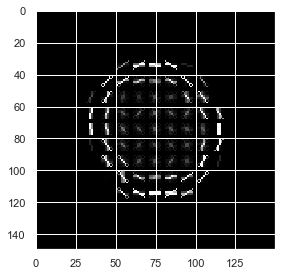

In [5]:
imshow(can_hog_im[90])

In [6]:
can_hog_feat.shape

(7272, 18432)

In [7]:
ncan_hog_im , ncan_hog_feat = get_hog_feat(ncan_re)

In [28]:
ncan_hog_im.shape

(6778, 150, 150)

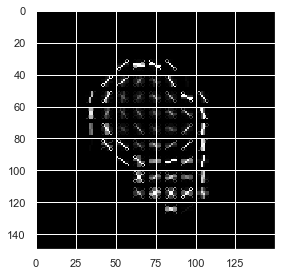

In [8]:
imshow(ncan_hog_im[90])

In [9]:
ncan_hog_feat.shape

(6778, 18432)

In [10]:
train_can , test_can = can_hog_feat[:6544] , can_hog_feat[6544:]
train_ncan , test_ncan = ncan_hog_feat[:6100] , ncan_hog_feat[6100:]

In [22]:
train_can[0].shape

(18432,)

In [11]:
can_labels = np.ones(train_can.shape[0])
nocan_labels = np.zeros(train_ncan.shape[0])


#Cancatenate Features and labels
features = np.concatenate((train_can,train_ncan),axis = 0)
labels = np.concatenate((can_labels,nocan_labels) , axis = 0)

# save labels and features to dataframe and shuffle data
train_df = pd.DataFrame(features)
train_df['labels'] = labels

train_df  = train_df.sample(frac=1).reset_index(drop=True)

In [17]:
# Convert Features to Array and Save it
Y_train = train_df.pop('labels')
X_train = train_df.values

In [20]:
print(X_train.shape)

(12644, 18432)


In [18]:
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [19]:
param_grid = {'C': [10, 100, 200], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=10, gamma=1, kernel=rbf .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
print(grid.best_estimator_)

In [ ]:
best_svc=SVC(C=200, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
            max_iter=-1, probability=False, random_state=None, shrinking=True,tol=0.001, verbose=False)

# Prediction On Validation Data

In [ ]:
y_pred_train = best_svc.predict(X_train)
print('Test Accuracy %.2f%%' % (metrics.accuracy_score(Y_test, y_pred_train)*100))

# Test Data

In [ ]:
tcan_labels = np.ones(tcan_hog_feat.shape[0])
tnocan_labels = np.zeros(tnocan_hog_feat.shape[0])


#Cancatenate Features and labels
features = np.concatenate((tcan_hog_feat,tnocan_hog_feat),axis = 0)
labels = np.concatenate((tcan_labels,tnocan_labels) , axis = 0)

# save labels and features to dataframe and shuffle data
test_df = pd.DataFrame(features)
test_df['labels'] = labels

test_df  = test_df.sample(frac=1).reset_index(drop=True)

In [ ]:
Y_test = test_df.pop('labels')
X_test = test_df.values

# Prediction On Test Data

In [ ]:
y_pred_test = best_svc.predict(X_test)
print('Test Accuracy %.2f%%' % (metrics.accuracy_score(Y_test, y_pred_test)*100))

In [ ]:
print(classification_report(Y_test, y_pred_test))

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_test, y_pred_test, target_names=['0','1'])

print(report)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_pred_test)
plot_confusion_matrix(cm = cm, normalize    = False,cmap ='Greens',
                      target_names = ['nocancer', 'cancer'],
                      title        = "Confusion Matrix")

In [ ]:
tn, fp, fn, tp = confusion_matrix(Y_test,y_pred_test).ravel()
print(tn, fp, fn, tp)

In [ ]:
print("Sensitivity %.2f%%" % ((tp / (tp + fn))*100))

# Save HOG Images for CNN Train

In [38]:
train_can , test_can = can_hog_im[:6544] , can_hog_im[6544:]
train_ncan , test_ncan = ncan_hog_im[:6100] , ncan_hog_im[6100:]

In [39]:
can_labels = np.ones(train_can.shape[0])
nocan_labels = np.zeros(train_ncan.shape[0])


#Cancatenate Features and labels
features = np.concatenate((train_can,train_ncan),axis = 0)
labels = np.concatenate((can_labels,nocan_labels) , axis = 0)

#reshape features array
features = np.reshape(features,(features.shape[0],150*150*1))

# save labels and features to dataframe and shuffle data
train_df = pd.DataFrame(features)
train_df['labels'] = labels

train_df  = train_df.sample(frac=1).reset_index(drop=True)

In [40]:
# Convert Features to Array and Save it
labels = train_df.pop('labels')
features = train_df.values

features = np.reshape(features,(features.shape[0],150,150,1))

In [41]:
features.shape

(12644, 150, 150, 1)

In [42]:
img = np.reshape(features[0],(150,150))

In [43]:
# Save test Features
np.savez_compressed('/Users/toothless/Downloads/Thesis_Results/HOG + CNN/data/Train_HOG_v2',features=features, labels=labels)

In [44]:
tcan_labels = np.ones(test_can.shape[0])
tnocan_labels = np.zeros(test_ncan.shape[0])


#Cancatenate Features and labels
features = np.concatenate((test_can,test_ncan),axis = 0)
labels = np.concatenate((tcan_labels,tnocan_labels) , axis = 0)

#reshape features array
features = np.reshape(features,(features.shape[0],150*150*1))

# save labels and features to dataframe and shuffle data
test_df = pd.DataFrame(features)
test_df['labels'] = labels

test_df  = test_df.sample(frac=1).reset_index(drop=True)

In [45]:
# Convert Features to Array and Save it
labels = test_df.pop('labels')
features = test_df.values

features = np.reshape(features,(features.shape[0],150,150,1))

In [46]:
# Save test Features
np.savez_compressed('/Users/toothless/Downloads/Thesis_Results/HOG + CNN/data/Test_HOG_v2',features=features, labels=labels)